### Part 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

### How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [4]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])[:, 0]

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []
    
    matrix = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, i1, i2, i3, i4, i5, i6) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
            

            matrix.append(np.array([[i1, i2, i3], [i2, i4, i5], [i3, i5, i6]]).astype(np.float32))
            
    # Returns M (matrix), E stuff
    return np.array(matrix), np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta)

In [3]:
def constructGraph(X, Y, T, dX, dY, dT):
    '''
    Input: 
        X: Initial X
        Y: Initial Y
        T: Initial Theta
        dX: delta X in Constraint
        dY: delta Y in Constraint
        dT: delta Theta in Constraint
        
    Output:
        Graph created from observations
    '''
    length = dX.shape[0]
    xCurr = X
    yCurr = Y
    tCurr = T
    graph = [[xCurr, yCurr, tCurr]]
    
    for constraintIndex in range(length):
        xNext = xCurr + dX[constraintIndex] * np.cos(tCurr) - dY[constraintIndex] * np.sin(tCurr)
        yNext = yCurr + dX[constraintIndex] * np.sin(tCurr) + dY[constraintIndex] * np.cos(tCurr)
        tNext = tCurr + dT[constraintIndex]
        
        graph.append([xNext, yNext, tNext])
        xCurr, yCurr, tCurr = xNext, yNext, tNext
    return np.array(graph).squeeze() - np.array([X, Y, T]).squeeze()



In [7]:
def getJacobian(i1, i2, dX, dY, dT, final):
    '''
    gives the Jacobian
    '''
    nodes = np.unique(np.concatenate([i1, i2]))
    num_edges = i1.shape[0]
    jacobian = np.zeros((3 * (num_edges + 1), 3 * len(nodes)))
    for i in range(num_edges):
        n1, n2 = i1[i], i2[i]
        mat1 = np.eye(3)
        theta = final[n2, 2]
        mat2 = -np.eye(3)
        mat1[0, 2] = -dX[i] * np.sin(theta) - (dY[i] * np.cos(theta))
        mat1[1, 2] = dX[i] * np.cos(theta) - (dY[i] * np.sin(theta))
        z = (final[n1, 2] - final[n2, 2] + dT[i]) / 2
        mat1[2, 2] = 1 / (np.cos(z) ** 2) * 0.5
        # mat1[2, 2] = np.cos(z) *
        mat2[2, 2] = mat1[2, 2] * -1
        jacobian[i * 3 : (i + 1) * 3, n1 * 3 : (n1 + 1) * 3] = mat1
        jacobian[i * 3 : (i + 1) * 3, n2 * 3 : (n2 + 1) * 3] = mat2
    
    jacobian[-3 : , 0 : 3] = np.eye(3)
    return jacobian


def getInformationMatrix(I, anchorMat):
    '''
    gives the information matrix
    '''
    num_edges = I.shape[0]
    info_mat = np.zeros((3 * (num_edges + 1), 3 * (num_edges + 1)))
    for i in range(num_edges):
        info_mat[i * 3 : (i + 1) * 3, i * 3 : (i + 1) * 3] = I[i]
    
    info_mat[-3:, -3:] = anchorMat
    
    return info_mat


0.25
0.04999999999999999
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.049999999999999975
0.0499999

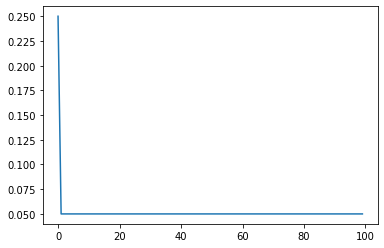

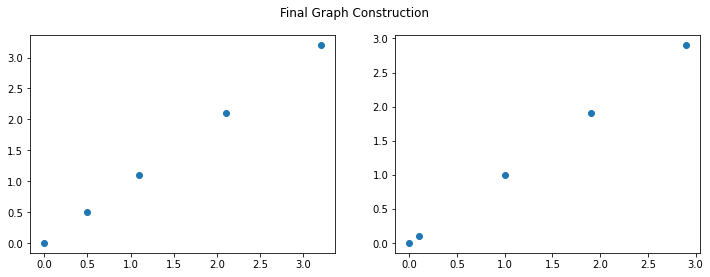

In [13]:
from scipy.linalg import cho_factor, cho_solve

def doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I):
    '''
    Input: 
        X: Initial X
        Y: Initial Y
        T: Initial Theta
        i1: First Index in index pair of Constraint
        i2: Second Index in index pair of Constraint
        dX: delta X in Constraint
        dY: delta Y in Constraint
        dT: delta Theta in Constraint
        I: Information Matrix
        
    Output:
        Optimized Graph
    '''
    
    fixIndex = -1
    length = i1.shape[0]
    for i in range(length):
        if np.abs(i2[i] - i1[i]) > 1:
            fixIndex = i
            break

    dX2, loopX = dX[:fixIndex], dX[fixIndex:]
    dY2, loopY = dY[:fixIndex], dY[fixIndex:]
    dT2, loopT = dT[:fixIndex], dT[fixIndex:]
    graph = constructGraph(X, Y, T, dX2, dY2, dT2)

    
    iterations = 100

    lr = 1
    loss_arr = []
    final = graph.copy()
    # nodes = np.unique(np.concatenate([i1, i2]))
    # final = np.random.randn(len(nodes), 3)

    for iteration in range(iterations):

        jacob = getJacobian(i1, i2, dX, dY, dT, final)
        anchor_mat = np.eye(3) * 1000
        info = getInformationMatrix(I, anchor_mat)
        lhs = jacob.T @ info @ jacob
        precalc = -1 * jacob.T @ info.T
        
        f = np.empty(3 * (i1.shape[0] + 1))
        for i in range(i1.shape[0]): # iterating thorugh all constraints
            n1 = i1[i]
            n2 = i2[i]
            newX = final[n1, 0] - final[n2, 0] + dX[i] * np.cos(final[n1, 2]) - dY[i] * np.sin(final[n1, 2])
            newY = final[n1, 1] - final[n2, 1] + dX[i] * np.sin(final[n1, 2]) + dY[i] * np.cos(final[n1, 2])
            newT = final[n1, 2] + dT[i] - final[n2, 2]
            newT = np.tan(newT / 2)
            # newT = np.sin(newT / 2)
            # newT = newT * np.sin(4 * np.pi ** 2 / newT)
            f[3 * i : 3 * (i+1)] = np.array([newX, newY, newT])
            
        f[-3:] = final[0]
        rhs = precalc @ f
        # c, low = cho_factor(lhs)
        # dx = cho_solve((c, low), rhs)
        dx = np.linalg.solve(lhs, rhs)
        final += lr * dx.reshape(-1, 3)
        
        loss = f.T @ info @ f
        print(loss)
        loss_arr.append(loss)
            
    # draw(final[:, 0], final[:, 1], final[:, 2])
    new_loss_arr = np.array(loss_arr)
    plt.plot(new_loss_arr)
    plt.show()

    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle("Final Graph Construction")
    ax[0].scatter(graph[:,0], graph[:,0]) # they want it along the diagonal (y = x)
    ax[1].scatter(final[:,0], final[:,0]) # they want it along the diagonal (y = x)
    # draw(final[:, 0], final[:, 1], final[:, 2])
    # for k in range(final.shape[0]):
    #     plt.scatter(final[:k, 0], final[:k, 1])
    #     plt.show()
        
    # plt.show()
    return final, loss_arr
        
X, Y, T = readVertex("../data/edges2.txt")


I, i1, i2, dX, dY, dT = readEdge("../data/edges2.txt")

optimizedGraph, loss = doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I)

In [14]:
print(optimizedGraph[0])
print(optimizedGraph[1])
print(optimizedGraph[2])
print(optimizedGraph[3])
print(optimizedGraph[4])

# print(optimizedGraph[82])
# for i in range(1,5):
#     print(i, optimizedGraph[i] - optimizedGraph[i - 1] - np.array([dX[i - 1], dY[i - 1], dT[i - 1]]))

[0. 0. 0.]
[1. 0. 0.]
[1.9 0.  0. ]
[2.9 0.  0. ]
[0.1 0.  0. ]
